## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/g/data1a/r78/rt1527/dea-intertidal


In [ ]:
pip install odc-geo --quiet

In [ ]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet --ignore-requires-python

In [ ]:
pip install pygeos

### Load packages

In [73]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import GeoBox, Geometry
from odc.algo import mask_cleanup
# import odc.geo.xr

from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import mostcommon_crs
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays
from dea_tools.coastal import tidal_tag
from coastlines.raster import model_tides

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Client Scheduler: tcp://127.0.0.1:46215 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 16 Memory: 47.42 GB


## Setup

In [4]:
dc = datacube.Datacube(app='Intertidal_elevation')
config = {'db_hostname': 'deadev.nci.org.au',
          'db_port': 6432,
          'db_database': 'ard_validation'}

dc_s2 = datacube.Datacube(config=config)

In [444]:
aoi = 'Wollogorang'
# aoi = 'McCarthur River'
# aoi = 'Greenbank'
# aoi = 'Seven Emu'

time_range = ('2020', '2021')
resolution = 10

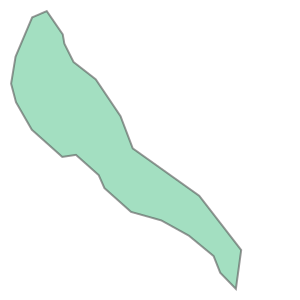

In [9]:
# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

In [74]:
from datacube.virtual import catalog_from_file

# Load in virtual product catalogue and select MNDWI product
catalog = catalog_from_file('configs/dea_virtual_product_landsat_s2.yaml')

In [339]:
geom = Geometry({'type': 'Polygon',
 'coordinates': (((137.9131894269534, -16.46432284398703),
   (137.91386521089527, -16.50946407308006),
   (137.9606564431977, -16.50880589134397),
   (137.9599698457682, -16.463666561285812),
   (137.9131894269534, -16.46432284398703)),)}, crs='EPSG:4326')

In [411]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [412]:
# Create the 'query' dictionary object
query_params = {
    'geopolygon': geom,
    'time': time_range,
'dask_chunks': {'x': 2048, 'y': 2048}, 
'resolution': (-10, 10),
'output_crs': 'epsg:32753'}

In [413]:
product = catalog['s2_nbart_ndwi']
s2_ds = product.load(dc_s2, **query_params)
s2_ds

,Array,Chunk
Bytes,506.07 MB,1.71 MB
Shape,"(296, 1509, 1133)","(1, 1509, 1133)"
Count,1711 Tasks,296 Chunks
Type,uint8,numpy.ndarray
,Array,Chunk
Bytes,506.07 MB,1.71 MB
Shape,"(296, 1509, 1133)","(1, 1509, 1133)"
Count,1711 Tasks,296 Chunks
Type,uint8,numpy.ndarray
,Array,Chunk


In [ ]:
# product = catalog['s2_nbart_ndwi']
# product.load(dc, **query_params)

In [414]:
s2_masked = s2_ds.ndwi.where(s2_ds.cloud_mask==1).compute()

In [446]:
s2_tide = tidal_tag(s2_masked.sel(time=slice('2020', '2022')), swap_dims=True)

Setting tide modelling location from dataset centroid: 137.82, -16.36


In [447]:
s2_tide

<xarray.DataArray 'ndwi' (tide_height: 134, y: 1509, x: 1133)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.54614127, -0.5453695 , -0.5419171 , ...,  0.2812823 ,
          0.22943723,  0.2710706 ],
        [-0.54259795, -0.54742295, -0.54178405, ...,  0.31513903,
          0.2058444 ,  0.26027396],
        [-0.55414015, -0.56521744, -0.5632113 , ...,  0.29221436,
          0.22758   ,  0.29020667],
...
        [-0.54936045, -0.5704202 , -0.59589475, ...,  0.66456056,
          0.66991407,  0.6573034 ],
        [-0.5453058 , -0.5603947 , -0.57967675, ...,  0.65639263,
          0.65979385,  0.6574648 ],
        [-0.5507734 , -0.5632571 , -0.5745948 , ...,  0.645857  ,
          0.6603339 ,  0.6619883 ]],

       [[-0.62994957, -0.6326264 , -0.6236559 , ...,  0.66541344,
          0.6735459 ,  0.68301886],
        [-0.6402878 , -0.6378812 , -0.61031723, ...,  0.71593094,
          0.6998051 ,  0.6914286 ],
        [-0.6168294 , -0.6043723 , -0.5841022 , ...,  0.6866538 ,
          0.6450381 ,  0.6593406 ],
        ...,
        [-0.5522703 , -0.54769796, -0.5942895 , ...,  0.21142854,
          0.23596671,  0.3333333 ],
        [-0.5511921 , -0.5486467 , -0.5788733 , ...,  0.27868852,
          0.2665877 ,  0.39511493],
        [-0.55629873, -0.58134407, -0.57655174, ...,  0.3068592 ,
          0.27530864,  0.38880482]]], dtype=float32)
Coordinates:
    spatial_ref  int32 32753
  * x            (x) float64 7.954e+05 7.954e+05 ... 8.067e+05 8.067e+05
  * y            (y) float64 8.196e+06 8.196e+06 ... 8.181e+06 8.181e+06
  * tide_height  (tide_height) float64 -1.05 -1.03 -0.996 ... 0.647 0.653 0.731
Attributes:
    crs:      epsg:32753
    units:    1
    nodata:   nan

In [448]:
pixel = s2_masked.isel(x=176, y=180).sortby('tide_height')
df = pixel.to_dataframe()[['tide_height', 'ndwi']]

In [449]:
df = df.rolling(20, min_periods=5, center=True).median()

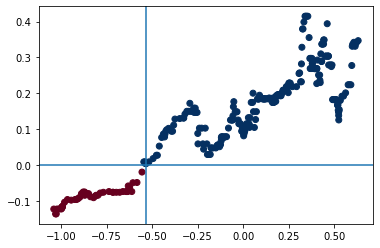

In [450]:
fig, ax = plt.subplots(1, 1)
ax.scatter(x=df.tide_height, y=df.ndwi, c=df.ndwi > 0, cmap='RdBu')
ax.axvline(df.where(df.ndwi > 0).tide_height.quantile(0.01))
ax.axhline(0)

In [224]:
from odc.algo import xr_quantile

In [451]:
s2_rolling = s2_tide.rolling(tide_height=20, min_periods=5, center=True).median()

In [452]:
a = s2_rolling.tide_height
k=len(s2_rolling.tide_height)
j=len(s2_rolling.y)
i=len(s2_rolling.x)
tide_3d = xr.DataArray(np.repeat(a.values, j*i).reshape((k, j, i)), coords=s2_rolling.coords)
tide_3d

<xarray.DataArray (tide_height: 134, y: 1509, x: 1133)>
array([[[-1.05 , -1.05 , -1.05 , ..., -1.05 , -1.05 , -1.05 ],
        [-1.05 , -1.05 , -1.05 , ..., -1.05 , -1.05 , -1.05 ],
        [-1.05 , -1.05 , -1.05 , ..., -1.05 , -1.05 , -1.05 ],
        ...,
        [-1.05 , -1.05 , -1.05 , ..., -1.05 , -1.05 , -1.05 ],
        [-1.05 , -1.05 , -1.05 , ..., -1.05 , -1.05 , -1.05 ],
        [-1.05 , -1.05 , -1.05 , ..., -1.05 , -1.05 , -1.05 ]],

       [[-1.03 , -1.03 , -1.03 , ..., -1.03 , -1.03 , -1.03 ],
        [-1.03 , -1.03 , -1.03 , ..., -1.03 , -1.03 , -1.03 ],
        [-1.03 , -1.03 , -1.03 , ..., -1.03 , -1.03 , -1.03 ],
        ...,
        [-1.03 , -1.03 , -1.03 , ..., -1.03 , -1.03 , -1.03 ],
        [-1.03 , -1.03 , -1.03 , ..., -1.03 , -1.03 , -1.03 ],
        [-1.03 , -1.03 , -1.03 , ..., -1.03 , -1.03 , -1.03 ]],

       [[-0.996, -0.996, -0.996, ..., -0.996, -0.996, -0.996],
        [-0.996, -0.996, -0.996, ..., -0.996, -0.996, -0.996],
        [-0.996, -0.996, -0.996, ..., -0.996, -0.996, -0.996],
        ...,
...
        ...,
        [ 0.647,  0.647,  0.647, ...,  0.647,  0.647,  0.647],
        [ 0.647,  0.647,  0.647, ...,  0.647,  0.647,  0.647],
        [ 0.647,  0.647,  0.647, ...,  0.647,  0.647,  0.647]],

       [[ 0.653,  0.653,  0.653, ...,  0.653,  0.653,  0.653],
        [ 0.653,  0.653,  0.653, ...,  0.653,  0.653,  0.653],
        [ 0.653,  0.653,  0.653, ...,  0.653,  0.653,  0.653],
        ...,
        [ 0.653,  0.653,  0.653, ...,  0.653,  0.653,  0.653],
        [ 0.653,  0.653,  0.653, ...,  0.653,  0.653,  0.653],
        [ 0.653,  0.653,  0.653, ...,  0.653,  0.653,  0.653]],

       [[ 0.731,  0.731,  0.731, ...,  0.731,  0.731,  0.731],
        [ 0.731,  0.731,  0.731, ...,  0.731,  0.731,  0.731],
        [ 0.731,  0.731,  0.731, ...,  0.731,  0.731,  0.731],
        ...,
        [ 0.731,  0.731,  0.731, ...,  0.731,  0.731,  0.731],
        [ 0.731,  0.731,  0.731, ...,  0.731,  0.731,  0.731],
        [ 0.731,  0.731,  0.731, ...,  0.731,  0.731,  0.731]]])
Coordinates:
    spatial_ref  int32 32753
  * x            (x) float64 7.954e+05 7.954e+05 ... 8.067e+05 8.067e+05
  * y            (y) float64 8.196e+06 8.196e+06 ... 8.181e+06 8.181e+06
  * tide_height  (tide_height) float64 -1.05 -1.03 -0.996 ... 0.647 0.653 0.731

In [453]:
test_min = xr_quantile(tide_3d.where((s2_rolling > 0)).to_dataset(name='ndwi'), [0.01], nodata=np.nan).ndwi.squeeze('quantile')
test_max = xr_quantile(tide_3d.where((s2_rolling < 0)).to_dataset(name='ndwi'), [0.99], nodata=np.nan).ndwi.squeeze('quantile')

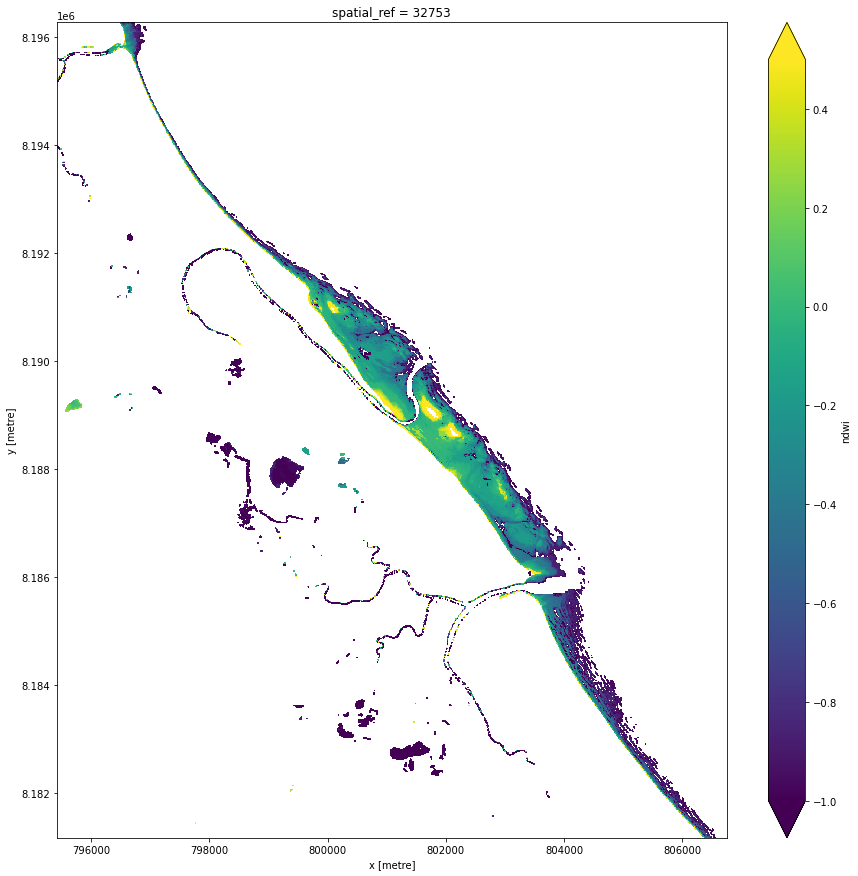

In [454]:
test_min.where(~test_max.isnull()).plot(vmax=0.5, vmin=-1.0, figsize=(15, 15))

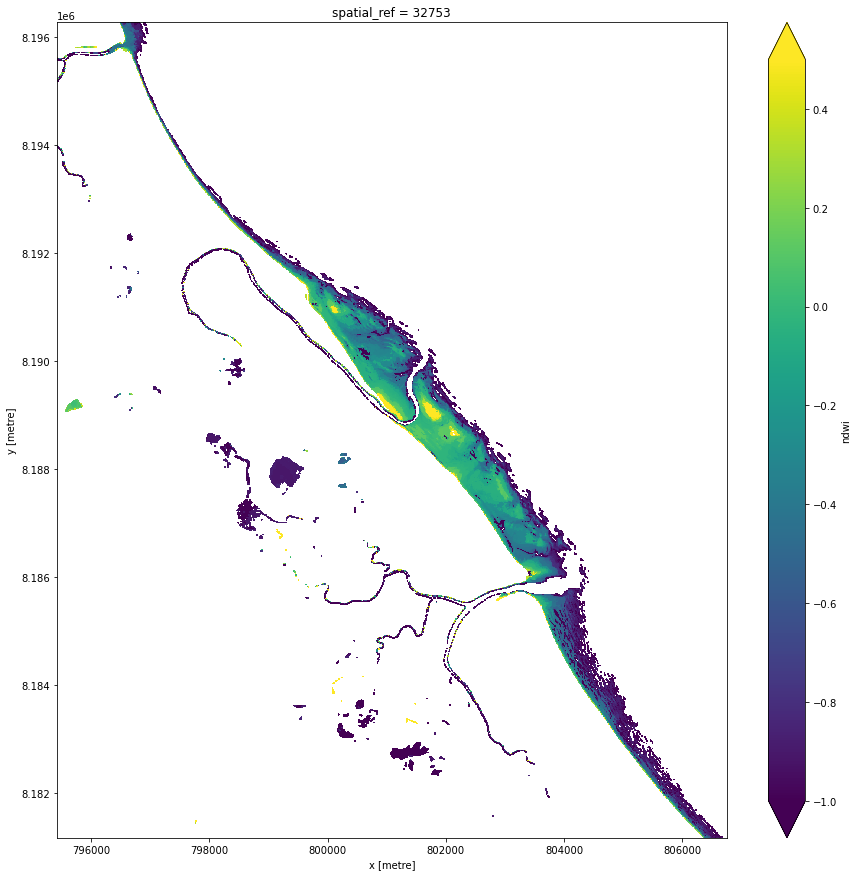

In [441]:
test_min.where(~test_max.isnull()).plot(vmax=0.5, vmin=-1.0, figsize=(15, 15))

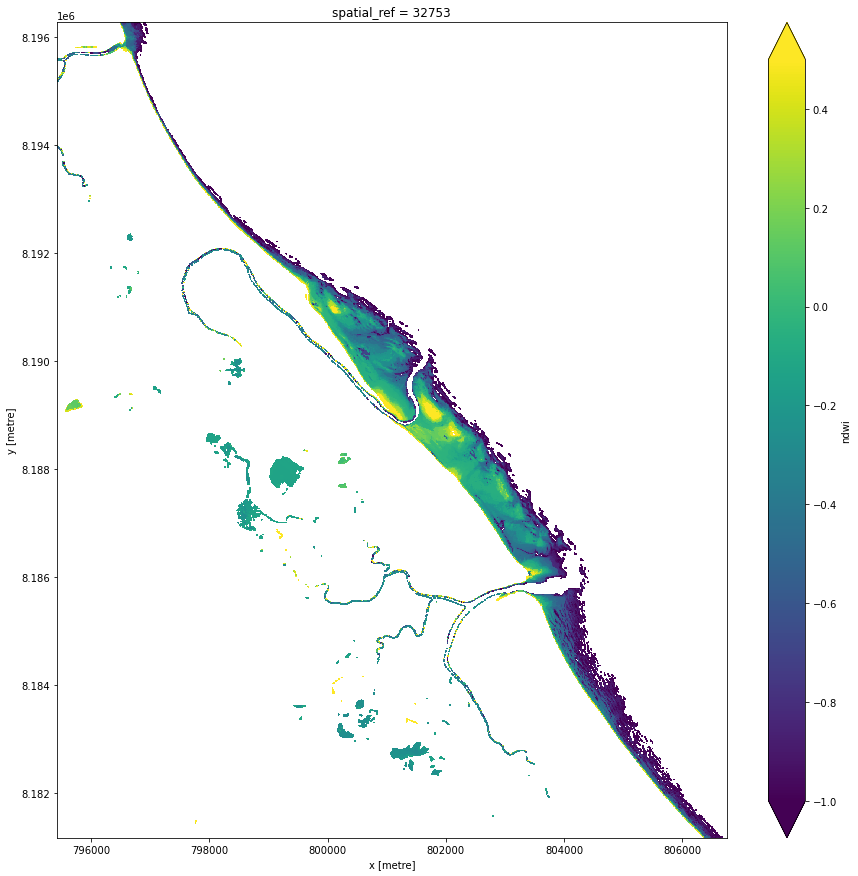

In [442]:
dem = ((test_max + test_min) / 2.0)
dem.plot(vmax=0.5, vmin=-1.0, figsize=(15, 15))

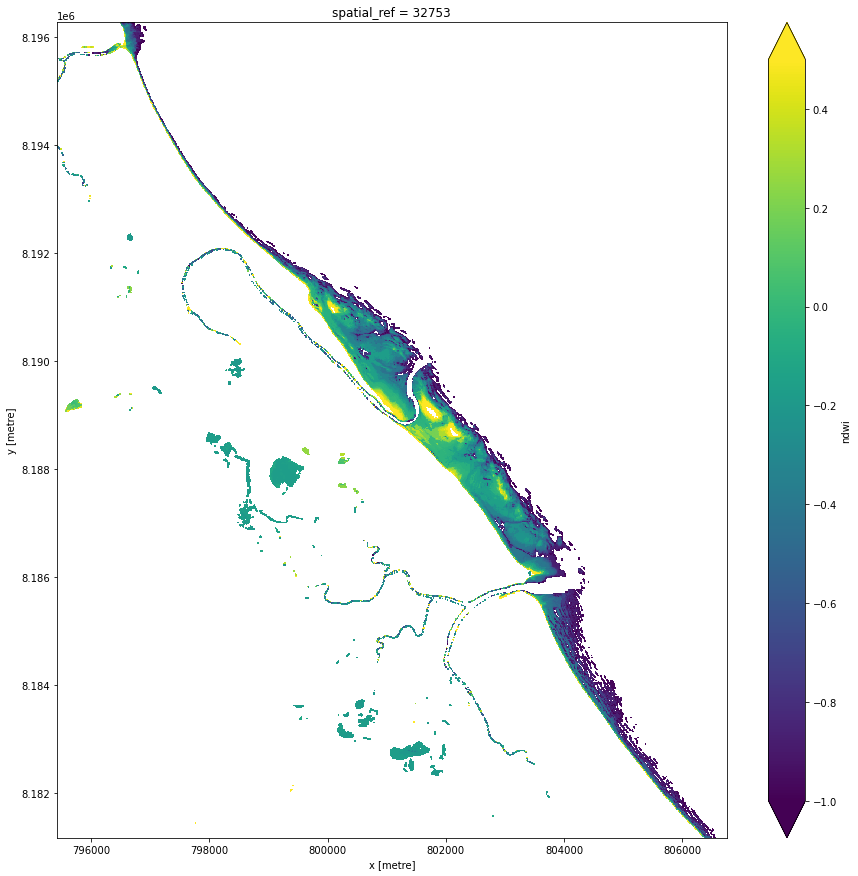

In [455]:
dem = ((test_max + test_min) / 2.0)
dem.plot(vmax=0.5, vmin=-1.0, figsize=(15, 15))

In [456]:
# dem = test_min.where(~test_max.isnull())

write_cog(dem, 'test_dem7.tif', overwrite=True)

PosixPath('test_dem7.tif')

In [381]:
dem

<xarray.DataArray 'ndwi' (y: 720, x: 799)>
array([[-0.132, -0.132, -0.132, ...,    nan,    nan,    nan],
       [-0.11 , -0.11 , -0.132, ...,    nan,    nan,    nan],
       [-0.11 , -0.11 , -0.11 , ...,    nan,    nan,    nan],
       ...,
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan]])
Coordinates:
    spatial_ref  int32 32753
  * y            (y) float64 8.25e+06 8.25e+06 8.25e+06 ... 8.243e+06 8.243e+06
  * x            (x) float64 6.801e+05 6.801e+05 ... 6.881e+05 6.881e+05

In [1]:
(test_max - test_min).plot(figsize=(15, 15), vmin=-0.5, vmax=0.5, cmap='RdBu')

NameError: name 'test_max' is not defined

In [431]:
class LinregressResult:
    def __init__(self, cov, cor, slope, intercept, pval, stderr):
        self.cov = cov
        self.cor = cor
        self.slope = slope
        self.intercept = intercept
        self.pval = pval
        self.stderr = stderr
    
    def __repr__(self):
        return 'LinregressResult({})'.format(
            ', '.join('{}={}'.format(k, getattr(self, k))
                      for k in dir(self) if not k.startswith('_'))
        )


def lag_linregress_3D(x, y, lagx=0, lagy=0, first_dim="time"):
    """
    Takes two xr.Datarrays of any dimensions (input data could be a 1D time series, or for example, have
    three dimensions e.g. time, lat, lon), and return covariance, correlation, regression slope and intercept,
    p-value, and standard error on regression between the two datasets along their aligned first dimension.
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Parameters
    ----------
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both sharing the same first dimension
    lagx, lagy : int, optional
        Optional integers giving lag values to assign to either of the data, with lagx shifting x, and lagy
        shifting y with the specified lag amount.
    first_dim : str, optional
        An optional string giving the name of the first dimension on which to align datasets. The default is
        'time'.
    Returns
    -------
    cov, cor, slope, intercept, pval, stderr : xarray DataArray
        Covariance, correlation, regression slope and intercept, p-value, and standard error on
        regression between the two datasets along their aligned first dimension.
    """
    # 1. Ensure that the data are properly alinged to each other.
    x, y = xr.align(x, y)

    # 2. Add lag information if any, and shift the data accordingly
    if lagx != 0:

        # If x lags y by 1, x must be shifted 1 step backwards. But as the 'zero-th' value is nonexistant, xr
        # assigns it as invalid (nan). Hence it needs to be dropped:
        x = x.shift(**{first_dim: -lagx}).dropna(dim=first_dim)

        # Next re-align the two datasets so that y adjusts to the changed coordinates of x:
        x, y = xr.align(x, y)

    if lagy != 0:

        y = y.shift(**{first_dim: -lagy}).dropna(dim=first_dim)
        x, y = xr.align(x, y)

    # 3. Compute data length, mean and standard deviation along time axis for further use:
    n = y.notnull().sum(dim=first_dim)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)

    # 4. Compute covariance along first axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / (n)

    # 5. Compute correlation along time axis
    cor = cov / (xstd * ystd)

    # 6. Compute regression slope and intercept:
    slope = cov / (xstd ** 2)
    intercept = ymean - xmean * slope

    # 7. Compute P-value and standard error
    # Compute t-statistics
    tstats = cor * np.sqrt(n - 2) / np.sqrt(1 - cor ** 2)
    stderr = slope / tstats

    from scipy.stats import t

    pval = t.sf(tstats, n - 2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return LinregressResult(cov, cor, slope, intercept, pval, stderr)

In [266]:
df.where(df.ndwi > 0)

,tide_height,ndwi
time,,
2018-12-27 01:11:38.605000,NaN,NaN
2017-12-07 01:07:15.458000,NaN,NaN
2019-12-17 01:11:40.400452,NaN,NaN
2019-12-02 01:11:44.371004,NaN,NaN
2019-11-17 01:11:43.982818,NaN,NaN
...,...,...
2021-06-29 01:11:46.615123,NaN,NaN
2019-07-05 01:11:50.658295,NaN,NaN
2018-07-15 01:07:25.461000,NaN,NaN


In [165]:
s2_masked.where(s2_masked > 0)

<xarray.DataArray 'ndwi' (time: 261, y: 500, x: 501)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[5.4046249e-01, 5.5119210e-01, 5.7496560e-01, ...,
         7.7382874e-01, 7.6602560e-01, 7.9672128e-01],
        [5.4322767e-01, 5.4852319e-01, 5.5874318e-01, ...,
         7.6320004e-01, 7.6260161e-01, 7.5450081e-01],
        [5.3923690e-01, 5.4706299e-01, 5.4495156e-01, ...,
         7.4800634e-01, 7.5161290e-01, 7.7265233e-01],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[2.4612737e-01, 2.5000000e-01, 2.5966850e-01, ...,
         3.1686956e-01, 3.1463745e-01, 3.1456044e-01],
        [2.5052488e-01, 2.3753865e-01, 2.6407227e-01, ...,
         3.1334963e-01, 3.1892648e-01, 3.0800000e-01],
        [2.4538808e-01, 2.4322492e-01, 2.5875086e-01, ...,
         2.9837620e-01, 3.1601125e-01, 2.9339269e-01],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
    spatial_ref  int32 32753
  * x            (x) float64 8.111e+05 8.111e+05 ... 8.161e+05 8.161e+05
  * y            (y) float64 8.177e+06 8.177e+06 ... 8.172e+06 8.172e+06
  * time         (time) datetime64[ns] 2017-01-26T01:07:20.460000 ... 2021-12...
    tide_height  (time) float64 -0.259 -0.192 0.156 ... -0.035 -0.876 -0.012
Attributes:
    crs:      epsg:32753
    units:    1
    nodata:   nan

In [205]:
# arr = np.array(s2_masked.tide_height).reshape(len(s2_masked.tide_height), len(s2_masked.y), len(s2_masked.x))
# da = xarray.DataArray(arr, coords=[('x', xs), ('y', ys), ('z', zs)])

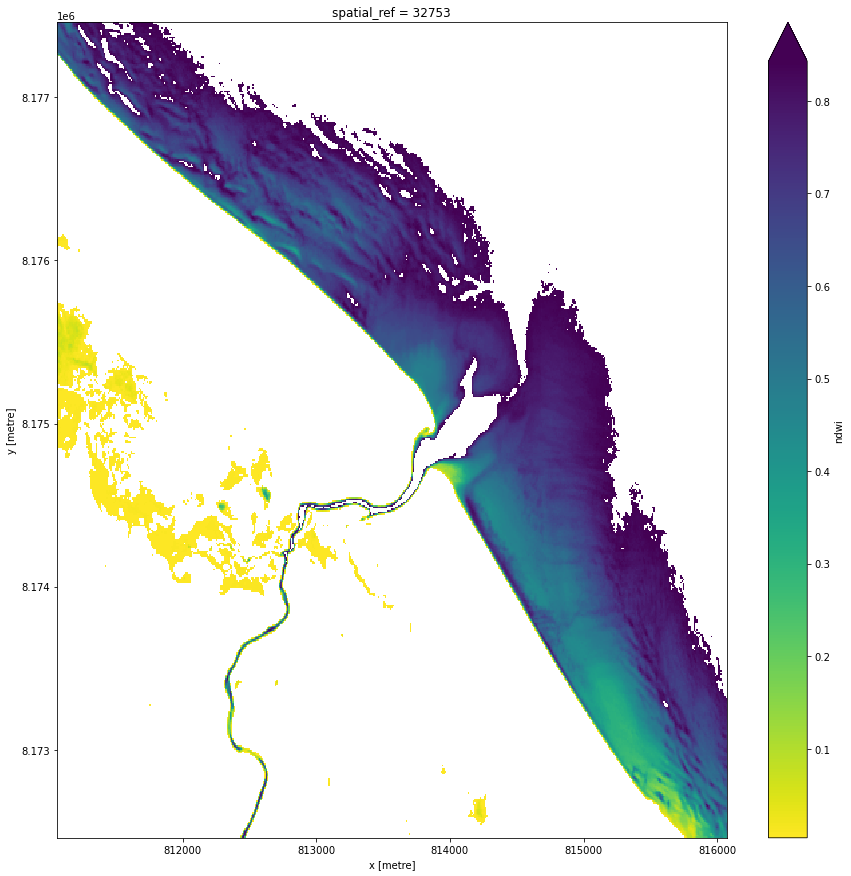

In [265]:
freq = (s2_masked > 0).mean(dim='time')


freq.where((freq > 0) & (freq < 0.85)).plot.imshow(cmap='viridis_r', robust=True, figsize=(15, 15))

In [354]:
s2_rolling = s2_tide.rolling(tide_height=10, min_periods=5, center=True).median()

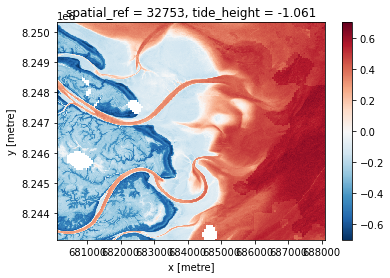

In [356]:
s2_rolling.isel(tide_height=10).plot()

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


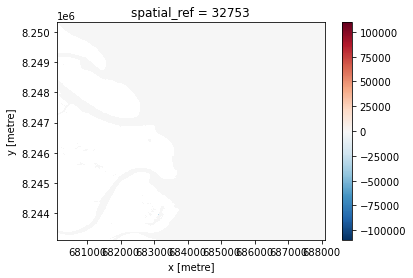

In [365]:
regress = lag_linregress_3D(x=s2_rolling.where(s2_rolling > 0), y=s2_rolling.tide_height, first_dim='tide_height')
regress.intercept.plot.imshow()

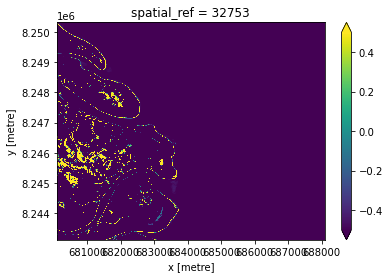

In [366]:
regress = lag_linregress_3D(x=s2_rolling, y=s2_rolling.tide_height, first_dim='tide_height')
regress.intercept.plot.imshow(vmin=-0.5, vmax=0.5)

In [208]:
# tide_3d.where(s2_masked > 0).quantile(0.05, dim='time')

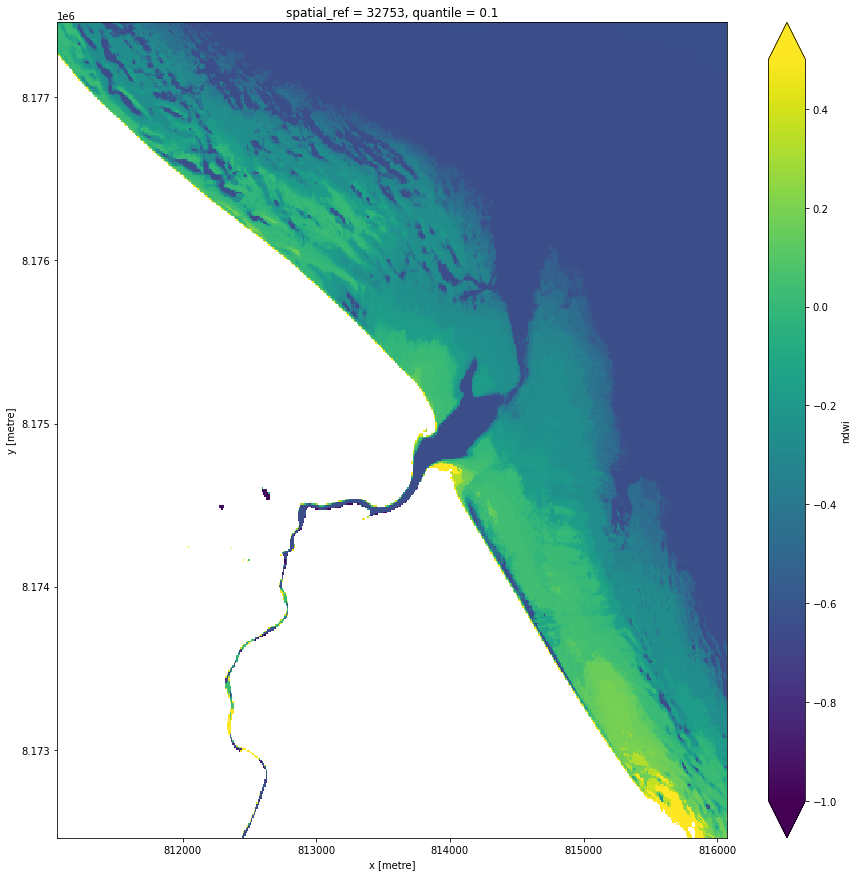

In [316]:
testing.plot.imshow(vmax=0.5, vmin=-1.0, figsize=(15, 15))

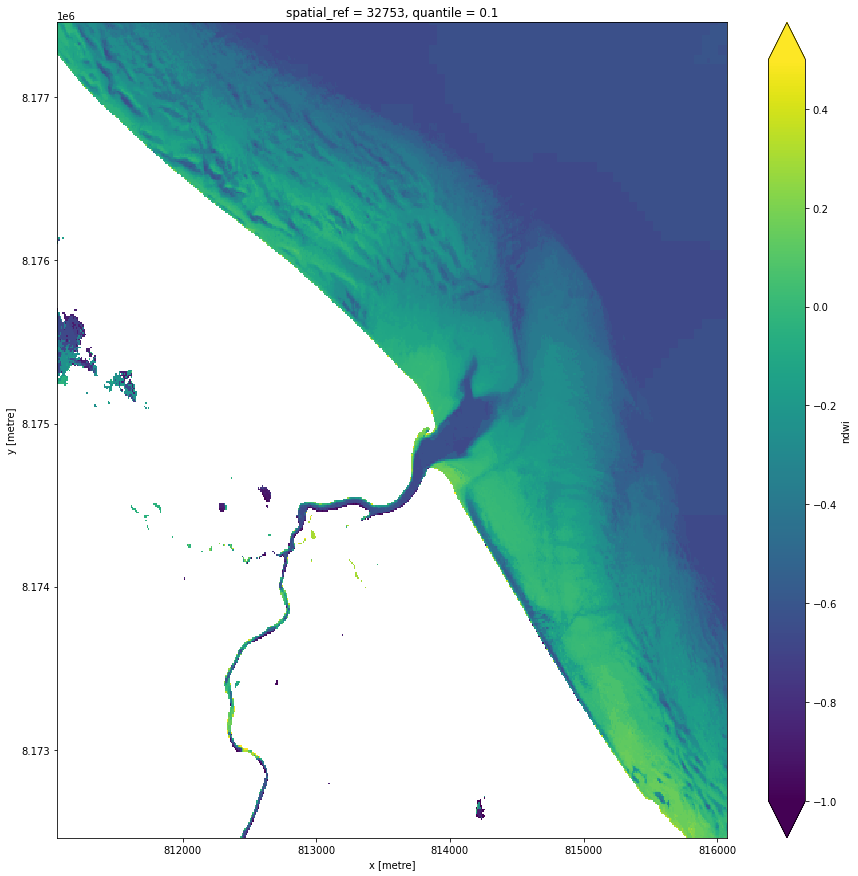

In [255]:
testing.plot.imshow(vmax=0.5, vmin=-1.0, figsize=(15, 15))

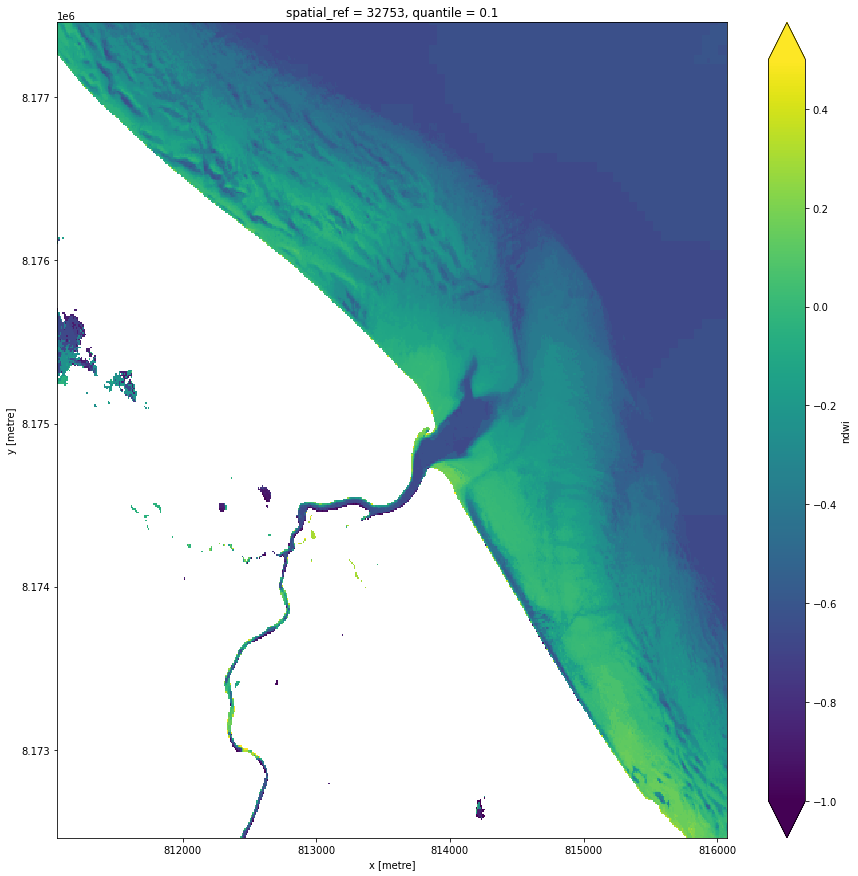

In [253]:
testing.plot.imshow(vmax=0.5, vmin=-1.0, figsize=(15, 15))

In [223]:
tide_3d.where(s2_masked > 0).isel(time=slice(0, 10)).quantile(0.05, dim='time')

<xarray.DataArray (y: 500, x: 501)>
array([[-0.0702, -0.0702, -0.0702, ..., -0.0528, -0.0528, -0.0528],
       [-0.0702, -0.0702, -0.0702, ..., -0.0528, -0.0528, -0.0528],
       [-0.0702, -0.0702, -0.0702, ..., -0.0528, -0.0528, -0.0528],
       ...,
       [    nan,     nan,     nan, ..., -0.0876, -0.0876, -0.0876],
       [    nan,     nan,     nan, ..., -0.105 , -0.0876, -0.0876],
       [    nan,     nan,     nan, ..., -0.0876, -0.0876, -0.0876]])
Coordinates:
  * x         (x) float64 8.111e+05 8.111e+05 8.111e+05 ... 8.161e+05 8.161e+05
  * y         (y) float64 8.177e+06 8.177e+06 8.177e+06 ... 8.172e+06 8.172e+06
    quantile  float64 0.05

In [200]:
s2_masked.tide_height.isel(time=-1)

<xarray.DataArray 'tide_height' ()>
array(-0.012)
Coordinates:
    spatial_ref  int32 32753
    time         datetime64[ns] 2021-12-31T01:11:47.354876
    tide_height  float64 -0.012